In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
import csv
import os

from app.core.PoseHelper import PoseHelper

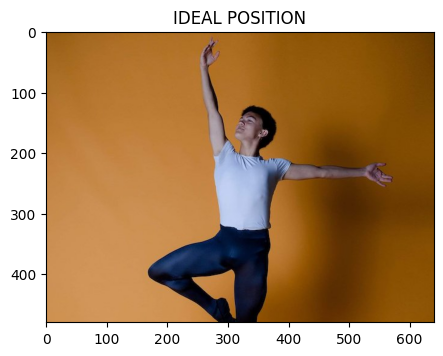

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False, min_detection_confidence=0.3, model_complexity=2
)

ideal = PoseHelper('app/media/straight_man.png')
ideal.detect_keypoints(verbose=False)
ideal.calculate_angles()
ideal.display_img([5,5],"IDEAL POSITION")
ideal.calculate_angles()
ideal_arms_and_angles = ideal.arms_and_angles

In [3]:

# for pose_name in os.listdir("C:\\Projects\\YogaPoseHelper\\app\\data\\suryanamaskarsteps"):
#         pose_dir_path = os.path.join(dataset_path, pose_name)

In [4]:
from app.core.graphics.graphics_assistant import draw_error_landmarks_2d
cap = cv2.VideoCapture(0)
while cap.isOpened():
    success, frame = cap.read()
    pose_name = "No pose detected"

    if success:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = pose.process(img)

        if results.pose_landmarks:
            # 
            helper = PoseHelper(img=img,mp_pose=mp_pose,pose=pose,mp_drawing=mp_drawing)
            helper.detect_keypoints(verbose=False)
            helper.calculate_angles()
            arms_and_angles = helper.arms_and_angles
            # draw the landmarks
            draw_error_landmarks_2d(
                arms_and_angles=arms_and_angles,
                ideal_arms_and_angles=ideal_arms_and_angles,
                img=img,
                landmark_list=results.pose_landmarks,
                pronounce_error_by=1,
                connections=mp_pose.POSE_CONNECTIONS,
            )

            # make the final image equal to the image we drew on
            frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cv2.putText(frame, pose_name, (5, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
    cv2.imshow("webcam feed", frame)

    if cv2.waitKey(10) & 0xFF == ord("q"):
        break
        

cap.release()
cv2.destroyAllWindows()